In [ ]:
pip install einops

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
from torch import Tensor

## inspired by VIT then include some libraries
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
import pandas as pd
import numpy as np
import random
from numpy import load


from tqdm import tqdm, trange
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torch.optim import Adam

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [5]:
# connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')


# address of initial data
CSV_SEQUENCES = "/content/gdrive/MyDrive/Colab Notebooks/iot_device_classification/new_csv_sequences"
NPZ_WINDOWS = "/content/gdrive/MyDrive/Colab Notebooks/iot_device_classification/npz_windows"
MODELS = "/content/gdrive/MyDrive/Colab Notebooks/iot_device_classification/models"

Mounted at /content/gdrive


In [6]:
# check the availability of cuda

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

Using device:  cuda (Tesla T4)


In [7]:
def load_data_make_split(npz_file, train_percentage):
    """
    Load training data (windows + one-hot labels) from compressed file. Split data into train and test set
    Arguments:
        - npz_file: The path to the *.npz file
        - train_percentage: the percentage of data used for training (and not testing), e.g. 0.8
    Returns:
        A 4-tuple of train and test data with labels: (x_train, y_train, x_test, y_test)
    """
    dict_data = load(npz_file)
    x = dict_data['x']
    y = dict_data['y']
    train_length = int(len(x)*train_percentage)
    x_train = x[:train_length]
    y_train = y[:train_length]
    x_test = x[train_length:]
    y_test = y[train_length:]
    return (x_train, y_train, x_test, y_test)

In [8]:
# test load_data_make_split()
x_train, y_train, x_test, y_test = load_data_make_split("{}/update_new_feature_all_days_all_devices.npz".format(NPZ_WINDOWS), 0.8)
print("shape of train windws: {}".format(x_train.shape))
print("shape of train labels: {}".format(y_train.shape))
print("shape of test windows: {}".format(x_test.shape))
print("shape of test labels: {}".format(y_test.shape))

shape of train windws: (1071459, 200, 8)
shape of train labels: (1071459, 1, 28)
shape of test windows: (267865, 200, 8)
shape of test labels: (267865, 1, 28)


In [9]:
## check number of devices in a dataset

all_labels = []
for i in range(len(y_train)):
  index = np.where(y_train[i][0] == True)
  k = index[0][0]
  all_labels.append(k)

for i in range(len(y_test)):
  index = np.where(y_test[i][0] == True)
  k = index[0][0]
  all_labels.append(k)

unique, count = np.unique(all_labels, return_counts = True)
useable_data = []
data_pair =dict()

# select the devices data points > 10000 as the supervised pretraining data
for i in range(len(unique)):
  if count[i] > 10000:
    useable_data.append(unique[i])
    # print(unique[i], count[i])
    data_pair[unique[i]] = count[i]
sorted_data_by_counts = sorted(data_pair.items(), key=lambda x:x[1])
print(sorted_data_by_counts)

[(24, 12041), (15, 12270), (6, 14034), (14, 15738), (2, 34720), (0, 36454), (27, 55804), (7, 61729), (1, 67218), (4, 68597), (10, 102906), (19, 111726), (22, 197876), (23, 228604), (5, 275855)]


In [10]:
all_device_names_dict = {0:'Smart Things', 1: 'Amazon Echo', 2:'Netatmo Welcome',3:'TP-Link Day Night Cloud camera', 4:'Samsung SmartCam', 5: 'Dropcam', 6: 'Withings Smart Baby Monitor', 7:'Belkin Wemo switch', 8:'TP-Link Smart plug',
                         9: 'iHome', 10:'Belkin wemo motion sensor', 11:'NEST Protect smoke alarm', 12:'Netatmo weather station',13:'Withings Smart scale',14:'Withings Aura smart sleep sensor',15:'Light Bulbs LiFX Smart Bulb',
                         16: 'Triby Speaker', 17:'PIX-STAR Photo-frame', 18 : 'HP Printer', 19: 'Samsung Galaxy Tab', 20: 'Nest Dropcam', 21:'Android Phone', 22:'Laptop', 23:'MacBook', 24:'Android Phone',
                         25: 'IPhone', 26:'MacBook/Iphone', 27:'Insteon Camera'}

In [11]:
## select the devices with enough amount of data a
total_av_idx = [0, 1, 2, 4, 5, 6, 7, 10, 14, 15, 22, 24, 27]


## random select 2 devices as unseen devices
unseen_idx = random.sample(total_av_idx, 2)

## the left will be seen devices
seen_idx = [i for i in total_av_idx if i not in unseen_idx]

print(seen_idx)
print(unseen_idx)

[0, 1, 2, 4, 6, 10, 14, 15, 22, 24, 27]
[5, 7]


In [12]:
num_unseen = len(unseen_idx)
num_seen = len(seen_idx)


# def one-hot index
def idxtoOneHot(idx, length):
  label_ohe = np.zeros((1,length))
  label_ohe[0][idx] = 1
  return label_ohe

# def merge dictionary
def Merge(dict1, dict2):
  res = {**dict1, **dict2}
  return res


# def dictionary for unseen, seen, and name
def generate_label_dict(unseen_idx, seed_idx):

  """
    generate the label of each device and its corresponding name

    like {9: 'iHome'}, we shuffle the data, 9 --> 10
    the data will be  {'iHome': 10}

    """
  unseen_dict = dict()
  seen_dict = dict()
  all_index_to_name = dict()
  seen_index_to_name = dict()
  unseen_index_to_name = dict()
  for i in range(0,num_seen):
    seen_dict[seen_idx[i]] = i
    seen_index_to_name[i] = all_device_names_dict[seen_idx[i]]
  for i in range(0,2):
    unseen_dict[unseen_idx[i]] = num_seen + i
    unseen_index_to_name[num_seen+i] = all_device_names_dict[unseen_idx[i]]
  total_dict = Merge(unseen_dict, seen_dict)
  all_index_to_name = Merge(seen_index_to_name, unseen_index_to_name)
  return unseen_dict, seen_dict, total_dict,all_index_to_name

## generate the training data
def seen_training_data(init_x_train, init_x_test, init_y_train, init_y_test, seen_dict):
  x_train_feature = []
  y_train_feature = []
  x_test_feature = []
  y_test_feature = []

  ## change from one-hot to label
  for i in range(len(init_y_train)):
    index = np.where(init_y_train[i][0] == True)
    k = index[0][0]
    if k in seen_idx:
      x_train_feature.append(init_x_train[i])
      # idx to new range
      new_k = seen_dict[k]
      y_train_feature.append(idxtoOneHot(new_k,len(seen_idx)))

  for i in range(len(init_y_test)):
    index = np.where(init_y_test[i][0] == True)
    k = index[0][0]
    if k in seen_idx:
      x_test_feature.append(init_x_test[i])
      # idx to new range
      new_k = seen_dict[k]
      y_test_feature.append(idxtoOneHot(new_k,len(seen_idx)))
  return np.array(x_train_feature), np.array(y_train_feature), np.array(x_test_feature), np.array(y_test_feature)



## extract features for the final test with both seen and unseen data
def feature_extraction_data_seen_and_unseen(init_x_train, init_x_test, init_y_train, init_y_test, attr_dict):

  x_train_attr = []
  y_train_attr = []
  x_test_attr = []
  y_test_attr = []

  attr_idx = [0,1,2,4,5,6,7,10,14,15,22,24,27]
  for i in range(len(init_y_train)):
    index = np.where(init_y_train[i][0] == True)
    k = index[0][0]
    if k in attr_idx:
      x_train_attr.append(init_x_train[i])
      # idx to new range
      new_k = attr_dict[k]
      y_train_attr.append(idxtoOneHot(new_k,len(attr_idx)))

  for i in range(len(init_y_test)):
    index = np.where(init_y_test[i][0] == True)
    k = index[0][0]
    if k in attr_idx:
      x_test_attr.append(init_x_test[i])
      # idx to new range
      new_k = attr_dict[k]
      y_test_attr.append(idxtoOneHot(new_k,len(attr_idx)))

  x_train_attr = np.array(x_train_attr)
  y_train_attr = np.array(y_train_attr)
  x_test_attr = np.array(x_test_attr)
  y_test_attr = np.array(y_test_attr)

  return x_train_attr,  y_train_attr, x_test_attr, y_test_attr


In [13]:
unseen_dict, seen_dict,total_dict,all_index_to_name = generate_label_dict(unseen_idx, seen_idx)

In [14]:
x_train_feature, y_train_feature, x_test_feature, y_test_feature = seen_training_data(x_train, x_test, y_train, y_test, seen_dict)
x_train_attr,  y_train_attr, x_test_attr, y_test_attr = feature_extraction_data_seen_and_unseen(x_train, x_test, y_train, y_test, total_dict)

In [15]:
print('unseen dictionary', unseen_dict)
print('seen dictionary', seen_dict)
print('total dictionary', total_dict)
print('index to name dictionary', all_index_to_name)

print("shape of train windws: {}".format(x_train_attr.shape))
print("shape of train labels: {}".format(y_train_attr.shape))
print("shape of test windows: {}".format(x_test_attr.shape))
print("shape of test labels: {}".format(y_test_attr.shape))


print("shape of train windws: {}".format(x_train_feature.shape))
print("shape of train labels: {}".format(y_train_feature.shape))
print("shape of test windows: {}".format(x_test_feature.shape))
print("shape of test labels: {}".format(y_test_feature.shape))

unseen dictionary {5: 11, 7: 12}
seen dictionary {0: 0, 1: 1, 2: 2, 4: 3, 6: 4, 10: 5, 14: 6, 15: 7, 22: 8, 24: 9, 27: 10}
total dictionary {5: 11, 7: 12, 0: 0, 1: 1, 2: 2, 4: 3, 6: 4, 10: 5, 14: 6, 15: 7, 22: 8, 24: 9, 27: 10}
index to name dictionary {0: 'Smart Things', 1: 'Amazon Echo', 2: 'Netatmo Welcome', 3: 'Samsung SmartCam', 4: 'Withings Smart Baby Monitor', 5: 'Belkin wemo motion sensor', 6: 'Withings Aura smart sleep sensor', 7: 'Light Bulbs LiFX Smart Bulb', 8: 'Laptop', 9: 'Android Phone', 10: 'Insteon Camera', 11: 'Dropcam', 12: 'Belkin Wemo switch'}
shape of train windws: (764405, 200, 8)
shape of train labels: (764405, 1, 13)
shape of test windows: (190837, 200, 8)
shape of test labels: (190837, 1, 13)
shape of train windws: (494250, 200, 8)
shape of train labels: (494250, 1, 11)
shape of test windows: (123408, 200, 8)
shape of test labels: (123408, 1, 11)


In [42]:

### SANE model design



# first conv2d to improve the performance
class NetPatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 1, feature_size: int = 200, emb_size: int = 8):
        self.feature_szie = feature_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a linear one to map the input to emb_size
            nn.Linear(emb_size, emb_size)
        )
        # sla_token: which aggrgate sequence level information
        self.sla_token = nn.Parameter(torch.randn(1,1,emb_size))

        # positional embedding : we let the model learn it, positional embedding is just a tensor of shape N_patchs
        self.positions = nn.Parameter(torch.randn(feature_size + 1, emb_size) )

    def forward(self, x: Tensor) -> Tensor:
        # print(x.shape)
        b, _, _, = x.shape

        x = self.projection(x)
        # repeat sla_token to all the samples number b
        sla_tokens = repeat(self.sla_token, '() n e -> b n e', b = b)

        # then prepend the sla token to the input
        x = torch.cat([sla_tokens, x], dim = 1)
        # add positional embedding
        x += self.positions

        return x

# NetPatchEmbedding()(k).shape

In [43]:
## self-attention mechanism

class NetMultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 8, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        ## calculate the Query key and value
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        # the result query key and values has a shape of BATCH, HEADS, SEQUENCE_LEN, EMBEDDING_SIZE
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values  = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)

        # sum up over the last axis   batch, num_heads, query_len, key_len
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)


        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out


#add residual value
class NetResidualAdd(nn.Module):
    def __init__(self, fn):
      super().__init__()
      self.fn = fn

    def forward(self, x, **kwargs):
      res = x
      x = self.fn(x, **kwargs)
      x += res
      return x


class NetFeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p : float = 0.):
      super().__init__(
          nn.Linear(emb_size, expansion * emb_size),
          nn.GELU(),
          nn.Dropout(),
          nn.Linear(expansion*emb_size, emb_size)
      )

class NetTransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 8,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            NetResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                NetMultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            NetResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                NetFeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


In [44]:

## adding multiple encoders if needed
class NetTransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 2, **kwargs):
        super().__init__(*[NetTransformerEncoderBlock(**kwargs) for _ in range(depth)])

## classification head for classification
class NetClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 8, n_classes: int = 11, n_attr = 3, n_extract = 20):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            # add one layer for feature extraction
            nn.Linear(emb_size, n_extract),

            # add one more layer for attribute extraction
            nn.Linear(n_extract, n_attr),
            nn.Linear(n_attr, n_classes))

##
class NetFormer(nn.Sequential):
    def __init__(self,
                in_channels: int = 1,
                feature_size: int = 200,
                emb_size: int = 8,
                depth: int = 2,
                n_classes: int = 11,
                n_attr = 3,
                n_extract = 20,
                **kwargs):
        super().__init__(
            NetPatchEmbedding(in_channels, feature_size, emb_size,),
            NetTransformerEncoder(depth, emb_size=emb_size, **kwargs),
            NetClassificationHead(emb_size, n_classes, n_attr)
        )

In [ ]:
summary(NetFormer(), (200,8), device='cpu')

In [46]:

# change label from one-hot to integer
y_train_labels = []
y_test_labels = []
for i in range(len(y_train_feature)):
  index = np.where(y_train_feature[i][0] == True)
  k = index[0][0]
  y_train_labels.append(k)

for i in range(len(y_test_feature)):
  index = np.where(y_test_feature[i][0] == True)
  k = index[0][0]
  y_test_labels.append(k)


# print(y_train_labels[0:10])

In [48]:
model = NetFormer().to(device)
N_EPOCHS = 30
LR = 0.0005

## reshape the input to feed into ZEST model
x_train = x_train_feature.reshape((-1,200,8))
x_test = x_test_feature.reshape((-1,200,8))

x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train_labels)
x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test_labels)
# print(y_test.shape)

In [49]:
## put the data into torch data loader
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
# print(summary(NetFormer(), (8, 200), device = 'cuda'))
# print(x_train.shape)

Using device:  cuda (Tesla T4)


In [50]:
## define 2 set to store the results for figure plots

acc_train_set = []
acc_test_set = []

loss_train_set = []
loss_test_set = []

In [ ]:
## train the model

optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()
for epoch in trange(N_EPOCHS, desc="Training"):
  train_loss = 0.0
  correct, total = 0, 0
  for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1} in training", leave=True,  mininterval=50, miniters=50):
    x, y = batch
    # print('shape of x :',x.shape)
    # print('shape of y :',y.shape)
    x, y = x.to(device), y.to(device)
    y_hat = model(x)
    # y_hat = y_hat.reshape((-1,1,28))
    # print('shape of y_hat', y_hat.shape)
    loss = criterion(y_hat, y)

    train_loss += loss.detach().cpu().item() / len(train_dataloader)
    correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
    total += len(x)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")
  print(f"Epoch {epoch + 1}/{N_EPOCHS} Training accuracy: {correct / total * 100:.2f}%")
  acc_train_set.append(correct / total)
  loss_train_set.append(train_loss)
  # Test loop
  with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_dataloader, desc="Testing", leave=True, mininterval=5, miniters=10):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_dataloader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")
    acc_test_set.append(correct / total)
    loss_test_set.append(test_loss)

In [ ]:
print(acc_train_set)
print(acc_test_set)
print(loss_train_set)
print(loss_test_set)

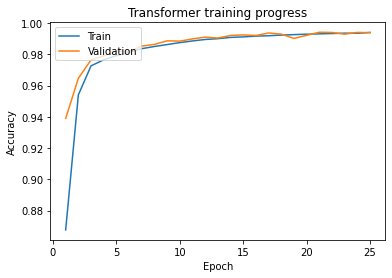

In [ ]:
import matplotlib.pyplot as plt
# draw training progress
x = np.linspace(1,25,25)
plt.plot(x,acc_train_set)
plt.plot(x,acc_test_set)
plt.title('Transformer training progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

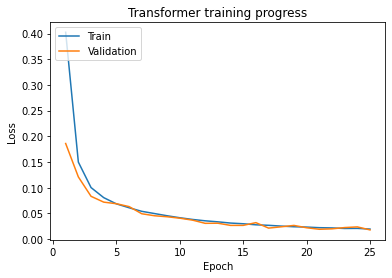

In [ ]:
import matplotlib.pyplot as plt
# draw training progress of loss
x = np.linspace(1,25,25)
plt.plot(x,loss_train_set)
plt.plot(x,loss_test_set)
plt.title('Transformer training progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [52]:
## save the model
torch.save(model.state_dict(), "{}/ZEST_0.pt".format(MODELS))

In [54]:
## load the saved model
model.load_state_dict(torch.load("{}/ZEST_0.pt".format(MODELS)))

<All keys matched successfully>

In [55]:

## combine the data to get the attributes for all the devices : seen and unseen
## !! just based on the model trained only on seen classes
new_x = np.concatenate((x_train_attr,x_test_attr))
new_y = np.concatenate((y_train_attr,y_test_attr))


y_train_attr = []
for i in range(len(new_y)):
  index = np.where(new_y[i][0] == True)
  k = index[0][0]
  y_train_attr.append(k)


new_x = new_x.reshape((-1,200,8))

new_x_train = torch.tensor(new_x)
new_y_train = torch.tensor(y_train_attr)


new_train_dataset = torch.utils.data.TensorDataset(new_x_train, new_y_train)
new_train_dataloader = torch.utils.data.DataLoader(new_train_dataset, batch_size=64, shuffle=True)

In [ ]:
## take the output of 2 layers to work as two level of features L and Lambda we mentioned in the paper

features_in_hook = []
features_out_hook = []

attr_in_hook = []
attr_out_hook = []



## define 2 hook to get the output of certain layer in the model

def feature_hook(module, fea_in, fea_out):
    features_in_hook.append(fea_in)
    features_out_hook.append(fea_out)
    return None



def attr_hook(module, attr_in, attr_out):
    attr_in_hook.append(attr_in)
    attr_out_hook.append(attr_out)
    return None

net = model

feature_layer_name = '2.2'
attr_layer_name = '2.3'
for (name, module) in net.named_modules():
  # print(name)
  if name == feature_layer_name:
    module.register_forward_hook(hook=feature_hook)
  elif name == attr_layer_name:
    module.register_forward_hook(hook=attr_hook)


prediction = []
real = []
with torch.no_grad():
  correct, total = 0, 0
  test_loss = 0.0
  for batch in tqdm(new_train_dataloader, desc="Testing"):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = net(x)
    for i in y:
      real.append(i)
    prediction.append(y_hat)

In [58]:
real_label = []
for j in range(len(real)):
  real_label.append(real[j].cpu().numpy())
real_label = np.array(real_label)
real_label.shape

# print(features_out_hook[0][1])

(955242,)

In [59]:
new_feature = []
for i in range(len(features_out_hook)):
  for j in range(len(features_out_hook[i])):
    new_feature.append(features_out_hook[i][j].cpu().numpy())

new_attr = []
for i in range(len(attr_out_hook)):
  for j in range(len(attr_out_hook[i])):
    new_attr.append(attr_out_hook[i][j].cpu().numpy())

new_feature =np.array(new_feature)
new_attr =np.array(new_attr)
print(new_feature.shape)
print(new_attr.shape)

(955242, 20)
(955242, 3)


In [60]:
attr_dict = dict()
for i in range(13):
  attr_dict[i] = []
print(attr_dict)


for i in range(len(real_label)):
  k = real_label[i]
  # print(k)
  attr_dict[k].append(new_attr[i])


## get the attribute vector for each devices
attr_lib = dict()
for key in attr_dict:
  # print(key)
  attr_lib[key] = np.mean(attr_dict[key],axis = 0)
print(attr_lib)

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: []}
{0: array([-18.469843,  23.125456, -10.08955 ], dtype=float32), 1: array([-10.145199 ,   3.885353 ,   5.9235253], dtype=float32), 2: array([-10.400902 ,  -2.385714 ,  -6.9343824], dtype=float32), 3: array([  3.25472 , -18.290081,  14.812773], dtype=float32), 4: array([ 3.8146322, 17.679535 , -8.597265 ], dtype=float32), 5: array([ 6.0684156, -5.3204083, -4.1698313], dtype=float32), 6: array([15.771193 ,  8.869213 ,  6.5278664], dtype=float32), 7: array([ 6.2723093, -2.2644265,  7.1916623], dtype=float32), 8: array([-15.127081 , -11.50587  ,  -1.3410503], dtype=float32), 9: array([-15.7846365,  -9.107595 ,  -2.739224 ], dtype=float32), 10: array([ 4.6775136,  3.3596647, 16.00385  ], dtype=float32), 11: array([-15.58578 ,  14.876772,  -5.219828], dtype=float32), 12: array([ 7.326816, -4.766336, -3.980715], dtype=float32)}


In [61]:
## normalize the attributes from 0-1
max_for_all = []
min_for_all = []
for i in attr_lib.keys():
  k = np.max(attr_lib[i])
  max_for_all.append(k)
  l = np.min(attr_lib[i])
  min_for_all.append(l)


maxi = np.max(max_for_all)
mini = np.min(min_for_all)

print(maxi)
print(mini)


def transfer_new_attr(mean, maxi, mini):
  new = []
  for i in range(len(mean)):
    x_scale = 1 * ((mean[i] - mini) / (maxi-mini))
    new.append(np.round(x_scale,2))
  return new

new_attr_lib = dict()
for key in attr_lib:
  new_attr_lib[key] = transfer_new_attr(attr_lib[key],maxi, mini)

new_attr_set = []
new_y_label = []
for i in range(len(real_label)):
    k = real_label[i]
    new_y_label.append(k)
    new_attr_set.append(new_attr_lib[k])

print(new_attr_lib)

23.125456
-18.469843
{0: [0.0, 1.0, 0.2], 1: [0.2, 0.54, 0.59], 2: [0.19, 0.39, 0.28], 3: [0.52, 0.0, 0.8], 4: [0.54, 0.87, 0.24], 5: [0.59, 0.32, 0.34], 6: [0.82, 0.66, 0.6], 7: [0.59, 0.39, 0.62], 8: [0.08, 0.17, 0.41], 9: [0.06, 0.23, 0.38], 10: [0.56, 0.52, 0.83], 11: [0.07, 0.8, 0.32], 12: [0.62, 0.33, 0.35]}


In [ ]:
seen_index = [0,1,2,3,4,5,6,7,8,9,10]
unseen_index = [11,12]
print(new_attr_lib)
seen_num = len(seen_index)
unseen_num = len(unseen_index)
attr_num = 3

#def attribute to name
attr_lib_name = dict()
for i in range(13):
  attr_lib_name[all_index_to_name[i]] = new_attr_lib[i]
attr_lib_name

In [63]:
seen_class_label = []
seen_class_attr = []
seen_class_features = []

unseen_class_label = []
unseen_class_attr  = []
unseen_class_features  = []


# save the 2 level features and attributes for CVAE model to learn
# the mapping between them
for i in range(len(real_label)):
  if real_label[i] in seen_index:
    seen_class_label.append(real_label[i])
    seen_class_attr.append(new_attr[i])
    seen_class_features.append(new_feature[i])
  elif real_label[i] in unseen_index:
    unseen_class_label.append(real_label[i])
    unseen_class_attr.append(new_attr[i])
    unseen_class_features.append(new_feature[i])


In [64]:
from collections import Counter
print(Counter(seen_class_label))
print(Counter(unseen_class_label))

Counter({8: 197876, 5: 102906, 3: 68597, 1: 67218, 10: 55804, 0: 36454, 2: 34720, 6: 15738, 4: 14034, 7: 12270, 9: 12041})
Counter({11: 275855, 12: 61729})


In [65]:
## save the data with features, attributes, and labels

from numpy import savez_compressed
from datetime import date

today = date.today()
seen_num = len(seen_idx)
unseen_num = len(unseen_idx)
attr_num = len(seen_class_attr[0])
print(seen_num, unseen_num, attr_num)


npz_file_seen = "{}/test_2_5_24_{}_seen_classes_{}_new_attribute_{}".format(NPZ_WINDOWS,seen_num, attr_num, today)
savez_compressed(npz_file_seen, x = seen_class_features, y = seen_class_label, attribute = seen_class_attr)

npz_file_unseen = "{}/test_2_5_24_{}_unseen_{}_new_attribute_{}".format(NPZ_WINDOWS,unseen_num, attr_num,today)
savez_compressed(npz_file_unseen, x = unseen_class_features, y = unseen_class_label, attribute = unseen_class_attr)

11 2 3


In [66]:
def load_data_make_split(npz_file, train_percentage, attr_dimension):
    """
    Load training data (windows + one-hot labels) from compressed file. Split data into train and test set

    Arguments:
        - npz_file: The path to the *.npz file
        - train_percentage: the percentage of data used for training (and not testing), e.g. 0.8
    Returns:
        A 4-tuple of train and test data with labels: (x_train, y_train, x_test, y_test)
    """
    dict_data = load(npz_file)
    x = dict_data['x']
    x = x.reshape((x.shape[0],20))
    y = dict_data['y']
    z = dict_data['attribute']
    z = z.reshape((z.shape[0],attr_dimension))

    train_length = int(len(x)*train_percentage)
    x_train = x[:train_length]
    y_train = y[:train_length]
    z_train = z[:train_length]
    x_test = x[train_length:]
    y_test = y[train_length:]
    z_test = z[train_length:]

    return (x_train, y_train, z_train, x_test, y_test, z_test)

In [ ]:
#### define the CVAE model for learning the mapping between Data space and Attributes space

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from collections import Counter
from numpy import savez_compressed
from datetime import date
from numpy import load
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Reshape, Lambda, Input, BatchNormalization, concatenate
from sklearn.metrics import accuracy_score
from sklearn import svm
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import random
from sklearn.metrics import accuracy_score
from sklearn import svm
from tensorflow.python.framework.ops import disable_eager_execution

attr_num = 3
seen_num = 11
unseen_num = 2

x_train, y_train, z_train, x_test, y_test, z_test = load_data_make_split("{}.npz".format(npz_file_seen),0.8, attr_num )
real_train_x, real_train_y, real_train_z, real_test_x, real_test_y, real_test_z  =  load_data_make_split("{}.npz".format(npz_file_unseen), 0.8,attr_num )

# reshape the label to be onehot form
labels_ohe= np.empty((y_train.shape[0],seen_num,1), dtype=np.float32)
for i in range(y_train.shape[0]):
  label_ohe = np.zeros((1,seen_num))
  label_ohe[0][int(y_train[i])] = 1
  labels_ohe[i] = label_ohe.T

labels_ohe_test= np.empty((y_test.shape[0], seen_num, 1), dtype=np.float32)
for i in range(y_test.shape[0]):
  label_ohe = np.zeros((1,seen_num))
  label_ohe[0][int(y_test[i])] = 1
  labels_ohe_test[i] = label_ohe.T

y_train = labels_ohe.reshape((y_train.shape[0],-1))
y_test = labels_ohe_test.reshape((y_test.shape[0],-1))

disable_eager_execution()

train_size = x_train.shape[0]
batch_size = 64
test_size = x_test.shape[0]


m = 64 # bacthsize
n_x = 20 # feature dimension
n_y = attr_num  # attribute vector
n_z = 4  # noise dimension
interNo = n_x  # number of neurons in the middle layer
n_epoch = 10  # number of epoches

# encoder input dimension
input_ic = Input(shape=[n_x+n_y], name = 'img_class' )
# attribute vector
cond  = Input(shape=[n_y] , name='class')
temp_h_q = Dense(interNo, activation='relu')(input_ic)
h_q_zd = Dropout(rate=0.2)(temp_h_q)
h_q = Dense(interNo, activation='relu')(h_q_zd)
# dense layer for mu
temp_h_q_2 = Dense(n_z, activation='linear')(h_q)
mu = Dense(n_z, activation='linear')(temp_h_q_2)
# dense layer for log
# log_sigma = Dense(n_z, activation='linear')(h_q)
log_sigma = Dense(n_z, activation='linear')(temp_h_q_2)

def sample_z(args):
    mu, log_sigma = args
    eps = tf.random.normal(shape=[n_z], mean=0., stddev=1.)
    return mu + tf.exp(log_sigma / 2) * eps

z = Lambda(sample_z)([mu, log_sigma])

# Depending on the keras version...
# z_cond = merge([z, cond] , mode='concat', concat_axis=1)
z_cond = concatenate([z, cond])

decoder_hidden = Dense(32, activation='relu')
decoder_out = Dense(n_x, activation='linear')
h_p = decoder_hidden(z_cond)
reconstr = decoder_out(h_p)
vae = Model(inputs=[input_ic , cond], outputs=[reconstr])

encoder = Model(inputs=[input_ic , cond], outputs=[mu])


d_in = Input(shape=[n_z+n_y])
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true), axis=1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * tf.keras.backend.sum(tf.exp(log_sigma) + tf.keras.backend.square(mu) - 1. - log_sigma, axis=1)
    #print 'kl : ' + str(kl)
    return recon + kl

encoder.summary()
decoder.summary()
vae.compile(optimizer="adam", loss=vae_loss)


X_train = np.concatenate([x_train , z_train], axis=1)
print(X_train.shape)
print ('Fitting VAE Model...')
vae.fit({'img_class' : X_train , 'class' : z_train}, x_train, batch_size=m, epochs=n_epoch)




def generate_reconstruction_loss(x_train, y_train, z_train, encoder, decoder, flag):

  diff_set = dict()
  sess = tf.compat.v1.Session()

  for i in range(200):
    a = x_train[i]
    # flag = 0 seen flag = 1 unseen
    if flag == 0:
      b_1 = y_train[i]
      for j in range(len(b_1)):
        if b_1[j] == 1:
          b = j
    else:
      b =  y_train[i]
    c = z_train[i]
    # print(a, b, c)
    enc_ip = np.concatenate((a, c))
    # print(enc_ip.shape)
    latent = encoder.predict([[enc_ip],[c] ])
    latent = latent.reshape((1,-1))
    c = c.reshape((1,-1))

    dec_ip = np.concatenate((latent, c) , axis=1)
    pseudoTrainData_test = decoder.predict(dec_ip)
    with sess.as_default():
      diff =tf.keras.backend.mean(tf.keras.backend.square(pseudoTrainData_test- a), axis=1).eval()
    if b not in diff_set.keys():
      diff_set[b] = diff
    else:
      before = diff_set[b]
      after = np.concatenate((before,diff))
      diff_set[b] = after
  for i in diff_set.keys():
    print('mean of {} : {} '.format(i,np.mean(diff_set[i])))

  return diff_set


diff_set_seen = generate_reconstruction_loss(x_train, y_train, z_train, encoder, decoder, flag = 0)
diff_set_unseen = generate_reconstruction_loss(real_train_x, real_train_y, real_train_z, encoder, decoder, flag = 1)


In [ ]:
### generate pseudo data for all the classes

def generate_pseudo_data(nSamples, label, attr_lib,noise_gen):
  attr = attr_lib[label]
  pseudoTrainData = []
  pseudoTrainLabels =[]
  pseudoTrainAttr = []
  for i in range(0,nSamples):
    pseudoTrainLabels.append(label)
    pseudoTrainAttr.append(attr)
  pseudoTrainAttr = np.array(pseudoTrainAttr)
  pseudoTrainLabels = np.array(pseudoTrainLabels)
  dec_ip = np.concatenate((noise_gen, pseudoTrainAttr) , axis=1)
  pseudoTrainData = decoder.predict(dec_ip)
  return pseudoTrainData, pseudoTrainLabels



def generating_pesudo_all_data(attr_lib):
  nSamples = 100000
  totalExs = nSamples
  sess = tf.compat.v1.Session()
  with sess.as_default():
    noise_gen = K.random_normal(shape=(totalExs, n_z), mean=0., stddev=1.).eval()

  total_pseudo_data = []
  total_pseudo_label = []
  for i in range(0,13):
    print('Generating Pseudo Data for class {}....... '.format(i))
    data_1, labels_1 = generate_pseudo_data(nSamples,i, attr_lib, noise_gen)
    if i == 0:
      total_pseudo_data = data_1
      total_pseudo_label = labels_1
    else:
      total_pseudo_data = np.concatenate((total_pseudo_data, data_1))
      total_pseudo_label = np.concatenate((total_pseudo_label, labels_1))
  # reshape the data
  total_pseudo_label = total_pseudo_label.reshape((-1,))

  return total_pseudo_data, total_pseudo_label



svm_train_data, svm_train_label = generating_pesudo_all_data(attr_lib)



In [ ]:

## training a supervised classifier based on the pesudo data generated
print ('Training SVM-100')
clf5 = svm.SVC(C=100)
clf5.fit(svm_train_data, svm_train_label)



x_train, y_train, z_train, x_test, y_test, z_test = load_data_make_split("{}.npz".format(npz_file_seen),0.8, attr_num )
final_train_x = np.concatenate((real_train_x,x_test),axis = 0)
print(final_train_x.shape)
final_train_y = np.concatenate((real_train_y,y_test),axis = 0)
print(final_train_y.shape)


print ('Predicting ZSL....')
pred_zsl = clf5.predict(real_train_x)
print(np.unique(pred_zsl))
print (accuracy_score(real_train_y , pred_zsl))


print ('Predicting GZSL...')
pred_gzsl = clf5.predict(final_train_x)
print(np.unique(pred_gzsl))
print (accuracy_score(final_train_y , pred_gzsl))

In [70]:
## show the accuracy for each class

def accuracy_for_each_class(real_train_y, pred_zsl):

  data_pair =dict()
  unique, count = np.unique(real_train_y, return_counts = True)
  for i in range(len(unique)):
    data_pair[unique[i]] = count[i]
    print(unique[i], count[i])
  print(data_pair)

  count_all = dict()

  for i in range(len(real_train_y)):
    b = real_train_y[i]
    if b not in count_all.keys():
      if pred_zsl[i] == real_train_y[i]:
        count_all[b] = 1
      # else:
        # print('real : {}, predict : {}'.format(real_train_y[i],pred_zsl[i]))
    else:
      if pred_zsl[i] == real_train_y[i]:
        before = count_all[b]
        after = before + 1
        count_all[b] = after
      # else:
      #   print('real : {}, predict : {}'.format(real_train_y[i],pred_zsl[i]))

  print(count_all)

  acc = dict()
  for i in data_pair.keys():
    acc[all_index_to_name[i]] = count_all[i]/data_pair[i]
  print(acc)
  return acc

In [ ]:
acc_zsl  = accuracy_for_each_class(real_train_y, pred_zsl)
acc_gzsl  = accuracy_for_each_class(final_train_y, pred_gzsl)

print(acc_zsl)
print(acc_gzsl)